## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

# Energy Shaping Controller

First we will design the energy shaping controller (only), and plot the closed-loop phase portrait.  Remember, this system is not actually stable at the upright.  It is only attractive!

<IPython.core.display.Javascript object>


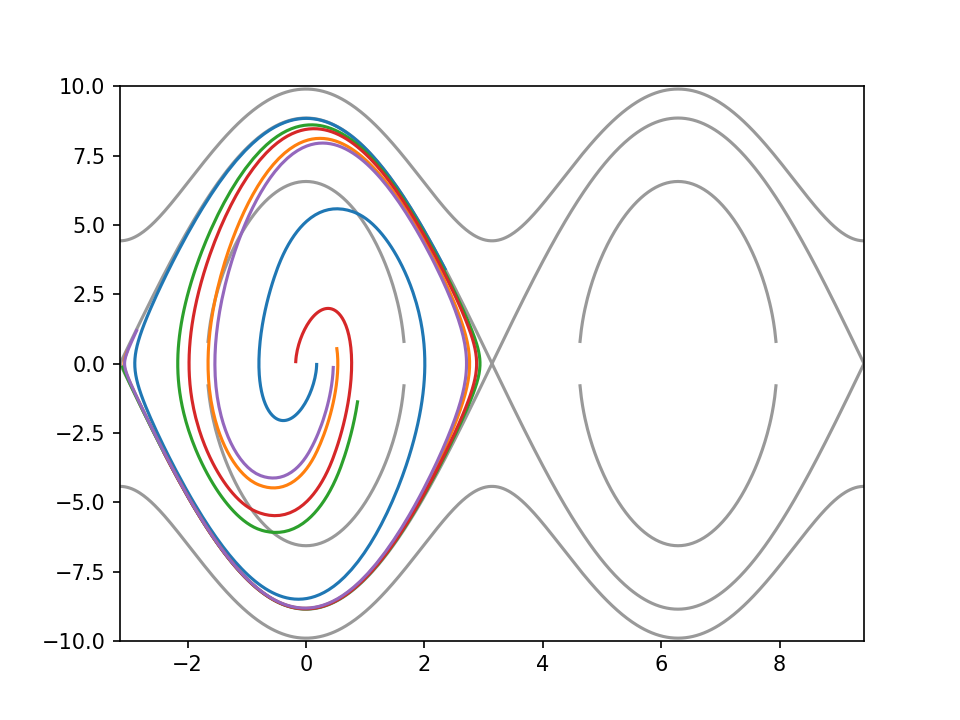

[2020-11-16 19:19:53.194] [console] [warning] Simulation time has changed since last Initialize() or AdvanceTo(). Resetting simulation time requires a call to Initialize(). This warning will become a hard error on or after 2020-12-01.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

from pydrake.all import (DiagramBuilder, Saturation, SignalLogger,
                         Simulator, wrap_to, VectorSystem)
from pydrake.examples.pendulum import (PendulumParams, PendulumPlant)
from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()


class EnergyShapingController(VectorSystem):

    def __init__(self, pendulum):
        VectorSystem.__init__(self, 2, 1)
        self.pendulum = pendulum
        self.pendulum_context = pendulum.CreateDefaultContext()
        self.SetPendulumParams(PendulumParams())
        
    def SetPendulumParams(self, params):
      self.pendulum_context.get_mutable_numeric_parameter(0).SetFromVector(params.CopyToVector())
      self.pendulum_context.SetContinuousState([np.pi, 0])
      self.desired_energy = self.pendulum.EvalPotentialEnergy(self.pendulum_context)

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
      self.pendulum_context.SetContinuousState(pendulum_state)
      params = self.pendulum_context.get_numeric_parameter(0)
      theta = pendulum_state[0]
      thetadot = pendulum_state[1]
      total_energy = self.pendulum.EvalPotentialEnergy(self.pendulum_context) + self.pendulum.EvalKineticEnergy(self.pendulum_context)
      output[:] = (params.damping() * thetadot - .1 * thetadot *
                         (total_energy - self.desired_energy))


def PhasePlot(pendulum):
    phase_plot = plt.figure()
    ax = phase_plot.gca()
    theta_lim = [-np.pi, 3. * np.pi]
    ax.set_xlim(theta_lim)
    ax.set_ylim(-10., 10.)

    theta = np.linspace(theta_lim[0], theta_lim[1], 601)  # 4*k + 1
    thetadot = np.zeros(theta.shape)
    context = pendulum.CreateDefaultContext()
    params = context.get_numeric_parameter(0)
    context.SetContinuousState([np.pi, 0])
    E_upright = pendulum.EvalPotentialEnergy(context)
    E = [E_upright, .1 * E_upright, 1.5 * E_upright]
    for e in E:
        for i in range(theta.size):
            v = ((e + params.mass() * params.gravity() * params.length() *
                  np.cos(theta[i])) /
                 (.5 * params.mass() * params.length() * params.length()))
            if (v >= 0):
                thetadot[i] = np.sqrt(v)
            else:
                thetadot[i] = float("nan")
        ax.plot(theta, thetadot, color=[.6, .6, .6])
        ax.plot(theta, -thetadot, color=[.6, .6, .6])

    return ax


builder = DiagramBuilder()

pendulum = builder.AddSystem(PendulumPlant())
ax = PhasePlot(pendulum)
saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
controller = builder.AddSystem(EnergyShapingController(pendulum))
builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

# visualizer = builder.AddSystem(PendulumVisualizer())
# builder.Connect(pendulum.get_output_port(0), visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(np.random.randn(2,))
    simulator.AdvanceTo(4)
    ax.plot(logger.data()[0, :], logger.data()[1, :])
    logger.reset()

# Swing-up and balance

Now we will combine our simple energy shaping controller with a linear controller that stabilizes the upright fixed point once we get close enough.  We'll read more about this approach in the Acrobot and Cart-Pole notes.

<IPython.core.display.Javascript object>


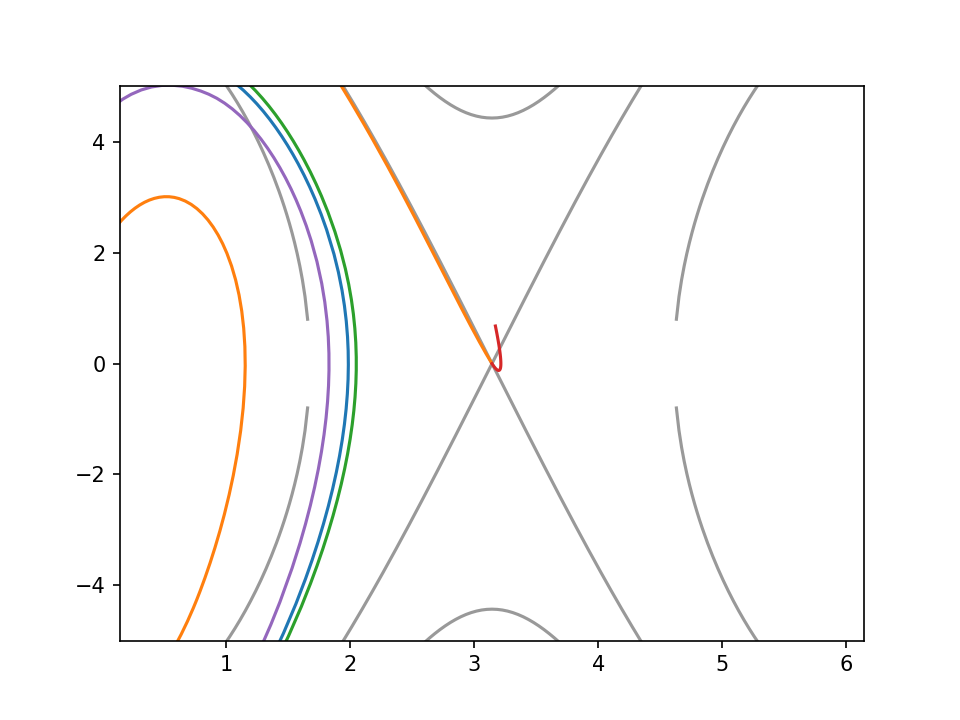

/home/sheep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DrakeDeprecationWarning: Use input_port.FixValue() instead of context.FixInputPort(). This will be removed from Drake on or after 2021-01-01.
  import sys
/home/sheep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DrakeDeprecationWarning: Use input_port.FixValue() instead of context.FixInputPort(). This will be removed from Drake on or after 2021-01-01.
/home/sheep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DrakeDeprecationWarning: Use input_port.FixValue() instead of context.FixInputPort(). This will be removed from Drake on or after 2021-01-01.
/home/sheep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DrakeDeprecationWarning: Use input_port.FixValue() instead of context.FixInputPort(). This will be removed from Drake on or after 2021-01-01.


(-5.0, 5.0)

In [3]:
from pydrake.all import Linearize, LinearQuadraticRegulator


def BalancingLQR(pendulum):
    context = pendulum.CreateDefaultContext()

    context.FixInputPort(0, [0])
    context.SetContinuousState([np.pi, 0])

    Q = np.diag((10., 1.))
    R = [1]

    linearized_pendulum = Linearize(pendulum, context)
    (K, S) = LinearQuadraticRegulator(linearized_pendulum.A(),
                                      linearized_pendulum.B(), Q, R)
    return (K, S)

  
class SwingUpAndBalanceController(VectorSystem):

    def __init__(self, pendulum):
        VectorSystem.__init__(self, 2, 1)
        (self.K, self.S) = BalancingLQR(pendulum)
        self.energy_shaping = EnergyShapingController(pendulum)
        self.energy_shaping_context = self.energy_shaping.CreateDefaultContext()

        # TODO(russt): Add a witness function to tell the simulator about the
        # discontinuity when switching to LQR.

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
        xbar = copy(pendulum_state)
        xbar[0] = wrap_to(xbar[0], 0, 2. * np.pi) - np.pi

        # If x'Sx <= 2, then use the LQR controller
        if (xbar.dot(self.S.dot(xbar)) < 2.):
            output[:] = -self.K.dot(xbar)
        else:
            self.energy_shaping_context.FixInputPort(0, pendulum_state)
            output[:] = self.energy_shaping.get_output_port(0).Eval(self.energy_shaping_context)
            
builder = DiagramBuilder()

pendulum = builder.AddSystem(PendulumPlant())
ax = PhasePlot(pendulum)
saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
controller = builder.AddSystem(SwingUpAndBalanceController(pendulum))
builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(np.random.randn(2,))
    simulator.AdvanceTo(4)
    ax.plot(logger.data()[0, :], logger.data()[1, :])
    logger.reset()
    
ax.set_xlim(np.pi - 3., np.pi + 3.)
ax.set_ylim(-5., 5.)
